# Install and Import dependencies

In [1]:
# # gym-anytrading is a reinforcement learning environment for stock trading based on OpenAI Gym.
# %conda install -c conda-forge gym
# %pip install gym-anytrading
# # install stable_baselines. RL Baselines3 Zoo is a training framework for Reinforcement Learning (RL). It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.
# %conda install -c conda-forge stable-baselines3
# # install quantstats. Quantitative statistics for analyzing and comparing financial asset returns.
# %conda install -c ranaroussi quantstats

In [2]:
# Gym and gym_anytrading
import gym
# from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading_optimized.gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions, CryptoEnv

# Stable Baselines3
from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import HParam
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv

# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import torch

plt.rcParams["figure.figsize"] = (20,10)
# Set matplotlib to dark mode
plt.style.use('dark_background')

from noisyenv.wrappers import RandomUniformScaleReward

ModuleNotFoundError: No module named 'gym_anytrading_optimized'

In [ ]:
# Check if GPU is available
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

GPU is available


# Load the data

<AxesSubplot:>

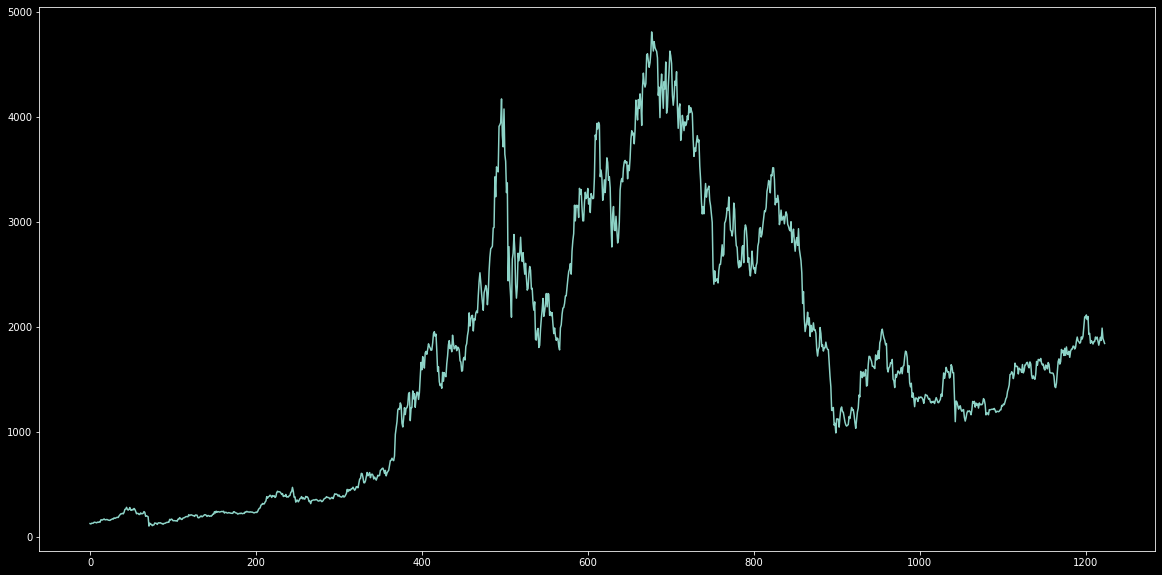

In [ ]:
csv_path = 'datasets/futures_pairs/ETHUSDT/1d_2020-01-01_2023-05-08.csv'
relative_csv_path = f'../../{csv_path}'
df = pd.read_csv(relative_csv_path, parse_dates=['open_time'])
df = df.sort_values('open_time').reset_index(drop=True)
# df = df[df['open_time'] >= '2022-01-01']
df['close'].plot()

In [ ]:
# Create a new df with the right format for the gym-anytrading environment
gymdf = pd.DataFrame()
gymdf['Date'] = df['open_time']
gymdf['Open'] = df['open']
gymdf['High'] = df['high']
gymdf['Low'] = df['low']
gymdf['Close'] = df['close']
gymdf['Volume'] = df['volume']

# Build Environment and Train

In [ ]:
# Create train and test splits
window_size = 10
train_test_split = 0.8
train_len = int(len(gymdf) * train_test_split)
test_len = len(gymdf) - train_len
complete_frame_bound = (10, len(gymdf))
training_frame_bound = (window_size, train_len)
test_frame_bound = (train_len, len(gymdf))
training_frame_bound, test_frame_bound

((10, 979), (979, 1224))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))


def normalize_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    
    signal_features = env.df.loc[:, ['Open', 'High', 'Low', 'Close']].to_numpy()[start:end]
    signal_features = scaler.fit_transform(signal_features)
    diff = np.insert(np.diff(prices), 0, 0)
    signal_features = np.column_stack((signal_features, diff))
    
    return prices, signal_features


class MyForexEnv(ForexEnv):
    _process_data = normalize_data

# Multi env parallel training

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import HParam


class HParamCallback(BaseCallback):
    """
    Saves the hyperparameters and metrics at the start of the training, and logs them to TensorBoard.
    """

    def _on_training_start(self) -> None:
        hparam_dict = {
            "algorithm": self.model.__class__.__name__,
            "learning rate": self.model.learning_rate,
            "gamma": self.model.gamma,
        }
        # define the metrics that will appear in the `HPARAMS` Tensorboard tab by referencing their tag
        # Tensorbaord will find & display metrics from the `SCALARS` tab
        metric_dict = {
            "rollout/ep_len_mean": 0,
            "rollout/ep_rew_mean": 0,
            "train/value_loss": 0.0,
        }
        self.logger.record(
            "hparams",
            HParam(hparam_dict, metric_dict),
            exclude=("stdout", "log", "json", "csv"),
        )

    def _on_step(self) -> bool:
        return True


In [ ]:
# Disable python warnings 
import warnings
warnings.filterwarnings('ignore')

# make sure tensorboard log directory exists
models_dir = 'auto_saved_models'
logdir = 'logs'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
if not os.path.exists(logdir):
    os.makedirs(logdir)

# Define the number of parallel environments
n_envs = 256

# Create a list of environment constructors
envs = [lambda: CryptoEnv(df=gymdf, window_size=window_size, frame_bound=training_frame_bound) for _ in range(n_envs)]

# Create the vectorized environment
envs = DummyVecEnv(envs)

# Create the normalizing wrapper
envs = VecNormalize(envs)

# Create new GYM environment for testing agent
my_test_env = CryptoEnv(df=gymdf, window_size=window_size, frame_bound=test_frame_bound)

### Paper: [What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study](https://arxiv.org/pdf/2006.05990.pdf)

| Environment | Policy MLP width | Policy MLP depth | Value MLP width | Value MLP depth |
|-------------|-----------------|------------------|-----------------|------------------|
| Ant         | 64              | 2                | 256             | 2                |
| HalfCheetah | 16-32           | 2                | 256             | 2                |
| Hopper      | 64              | 2                | 256             | 2                |
| Humanoid    | 64              | 2                | 256             | 2                |
| Walker2d    | 64              | 2                | 256             | 2                |

### Summary table of median best values

| Network | Width | Depth |
|---------|-------|-------|
| Policy  | 16-32 units per layer | Two hidden layers |
| Value   | 256 units per layer   | Two hidden layers |

In [ ]:
# paper: https://arxiv.org/pdf/2102.10456.pdf 

def linear_decay_clip_range(progress_remaining):
    initial_clip_range = 0.2 # or any value you want
    final_clip_range = 0.05 # or any value you want
    decay_factor = progress_remaining
    return decay_factor * (initial_clip_range - final_clip_range) + final_clip_range

def exponential_decay_clip_range(progress_remaining):
    initial_clip_range = 0.2 # or any value you want
    final_clip_range = 0.05 # or any value you want
    alpha = 0.99 # or any value you want
    decay_factor = alpha ** (100 * (1 - progress_remaining))
    return decay_factor * (initial_clip_range - final_clip_range) + final_clip_range

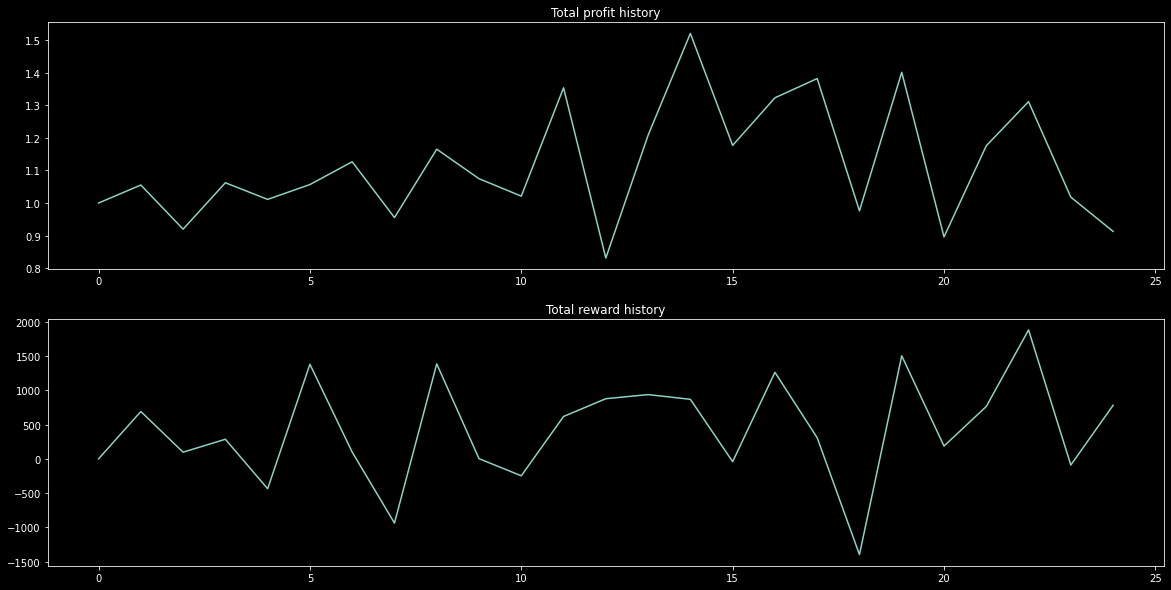

24/100. Total reward test: 782.59, Total profit test: 0.91 Elapsed time: 0d 4h 43m 49s, estimated remaining time: 0d 14h 58m 48s


In [ ]:
'''
Default Hyperparameters:

    n_steps: 2048,
    batch_size: 64,
    n_epochs: 10,
    gamma: 0.99,
    learning_rate: 0.00025,
    ent_coef: 0.0,
    clip_range: 0.2,
    vf_coef: 0.5,
    max_grad_norm: 0.5,
    gae_lambda: 0.95,
    
    
Best Hyperparameters from experiments:

    ent_coef: 0.01, 0.1

For BTC ent_coef = 0.01 seems to be best, for ETH it's 0.1
'''
# Instantiate the agent
# Set the upper limit for the random seed value
MAX_SEED = 2**32 - 1

# Generate a random seed value
seed = 0 #random.randint(0, MAX_SEED)
print(f'Seed: {seed}')

# Define the policy and value network architectures
policy_kwargs = dict(
    net_arch=dict(
        pi=[64, 64], # policy network
        vf=[256, 256] # value network
    ),
    activation_fn=torch.nn.Tanh # activation function
)

# create new model
model = PPO('MlpPolicy', envs, policy_kwargs=policy_kwargs, ent_coef=0.01, batch_size=256, seed=seed)
# model.clip_range = exponential_decay_clip_range

# load preexisting model to keep training
# model_name = f"ppo_btc_1M_simple_reward_hl.zip"
# model = PPO.load(model_name, env=envs, ent_coef=0.1, batch_size=512)
# model.clip_range = exponential_decay_clip_range

# Train the agent
TIMESTEPS = 1000000 * 100
TIMESTEPS_PER_ITERATION = 1000000
n_updates = int(TIMESTEPS / TIMESTEPS_PER_ITERATION)

import time
from IPython.display import clear_output, display
start_time = time.time()

reward_history_test = [0]
profit_history_test = [1]

for i in range(n_updates):
    model.learn(total_timesteps=TIMESTEPS_PER_ITERATION, reset_num_timesteps=False, tb_log_name="PPO")
    # model.learn(total_timesteps=TIMESTEPS_PER_ITERATION, reset_num_timesteps=False, tb_log_name="PPO", callback=HParamCallback())
    
    # Evaluate the current model with test data
    obs = my_test_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = my_test_env.step(action)
        
    # Append rewards and profits to history
    reward_history_test.append(info['total_reward'])
    profit_history_test.append(info['total_profit'])

    # Update the chart
    clear_output(wait=True) # Clear the previous chart

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1) # Added this line to create two subplots

    # Plot the total profit on the first subplot
    ax1.plot(profit_history_test, label='Total profit test')
    ax1.set_title('Total profit history') # Added this line to set the title of the first subplot

    # Plot both rewards on the second subplot
    ax2.plot(reward_history_test, label='Total reward test')
    ax2.set_title('Total reward history') # Added this line to set the title of the second subplot

    # Show the figure
    plt.show()
    plt.pause(0.01)

    # model.save(f'{models_dir}/{TIMESTEPS*i}.zip')
    
    elapsed_time = time.time() - start_time
    remaining_time = (elapsed_time / (i + 1)) * (n_updates - (i + 1))
    elapsed_hours, elapsed_remainder = divmod(int(elapsed_time), 3600)
    elapsed_minutes, elapsed_seconds = divmod(elapsed_remainder, 60)
    remaining_hours, remaining_remainder = divmod(int(remaining_time), 3600)
    remaining_minutes, remaining_seconds = divmod(remaining_remainder, 60)
    elapsed_days, elapsed_hours = divmod(elapsed_hours, 24)
    remaining_days, remaining_hours = divmod(remaining_hours, 24)
    print(f"{i+1}/{n_updates}. Total reward test: {round(info['total_reward'], 2)}, Total profit test: {round(info['total_profit'], 2)} "
          f"Elapsed time: {elapsed_days:.0f}d {elapsed_hours:.0f}h {elapsed_minutes:.0f}m {elapsed_seconds:.0f}s, "
          f"estimated remaining time: {remaining_days:.0f}d {remaining_hours:.0f}h {remaining_minutes:.0f}m {remaining_seconds:.0f}s")


# Save the agent
new_model_name = f"eth_100M_batch_size_256_envs_256_RandomUniformScaleReward_s{seed}.zip"
print(f'Saving model as {new_model_name}')
model.save(new_model_name)

# Backtest

In [ ]:
backtest_string = f'python backtester/backtester.py --ai training/Reinforcement_learning/{new_model_name} --klines {csv_path}'
backtest_string

'python backtester/backtester.py --ai training/Reinforcement_learning/eth_100M_batch_size_256_envs_256_ent_0.05_s0.zip --klines datasets/futures_pairs/ETHUSDT/1d_2020-01-01_2023-05-08.csv'

In [ ]:
%%capture 
%cd C:\dev\Python\Mastermind\mastermind
! {backtest_string}

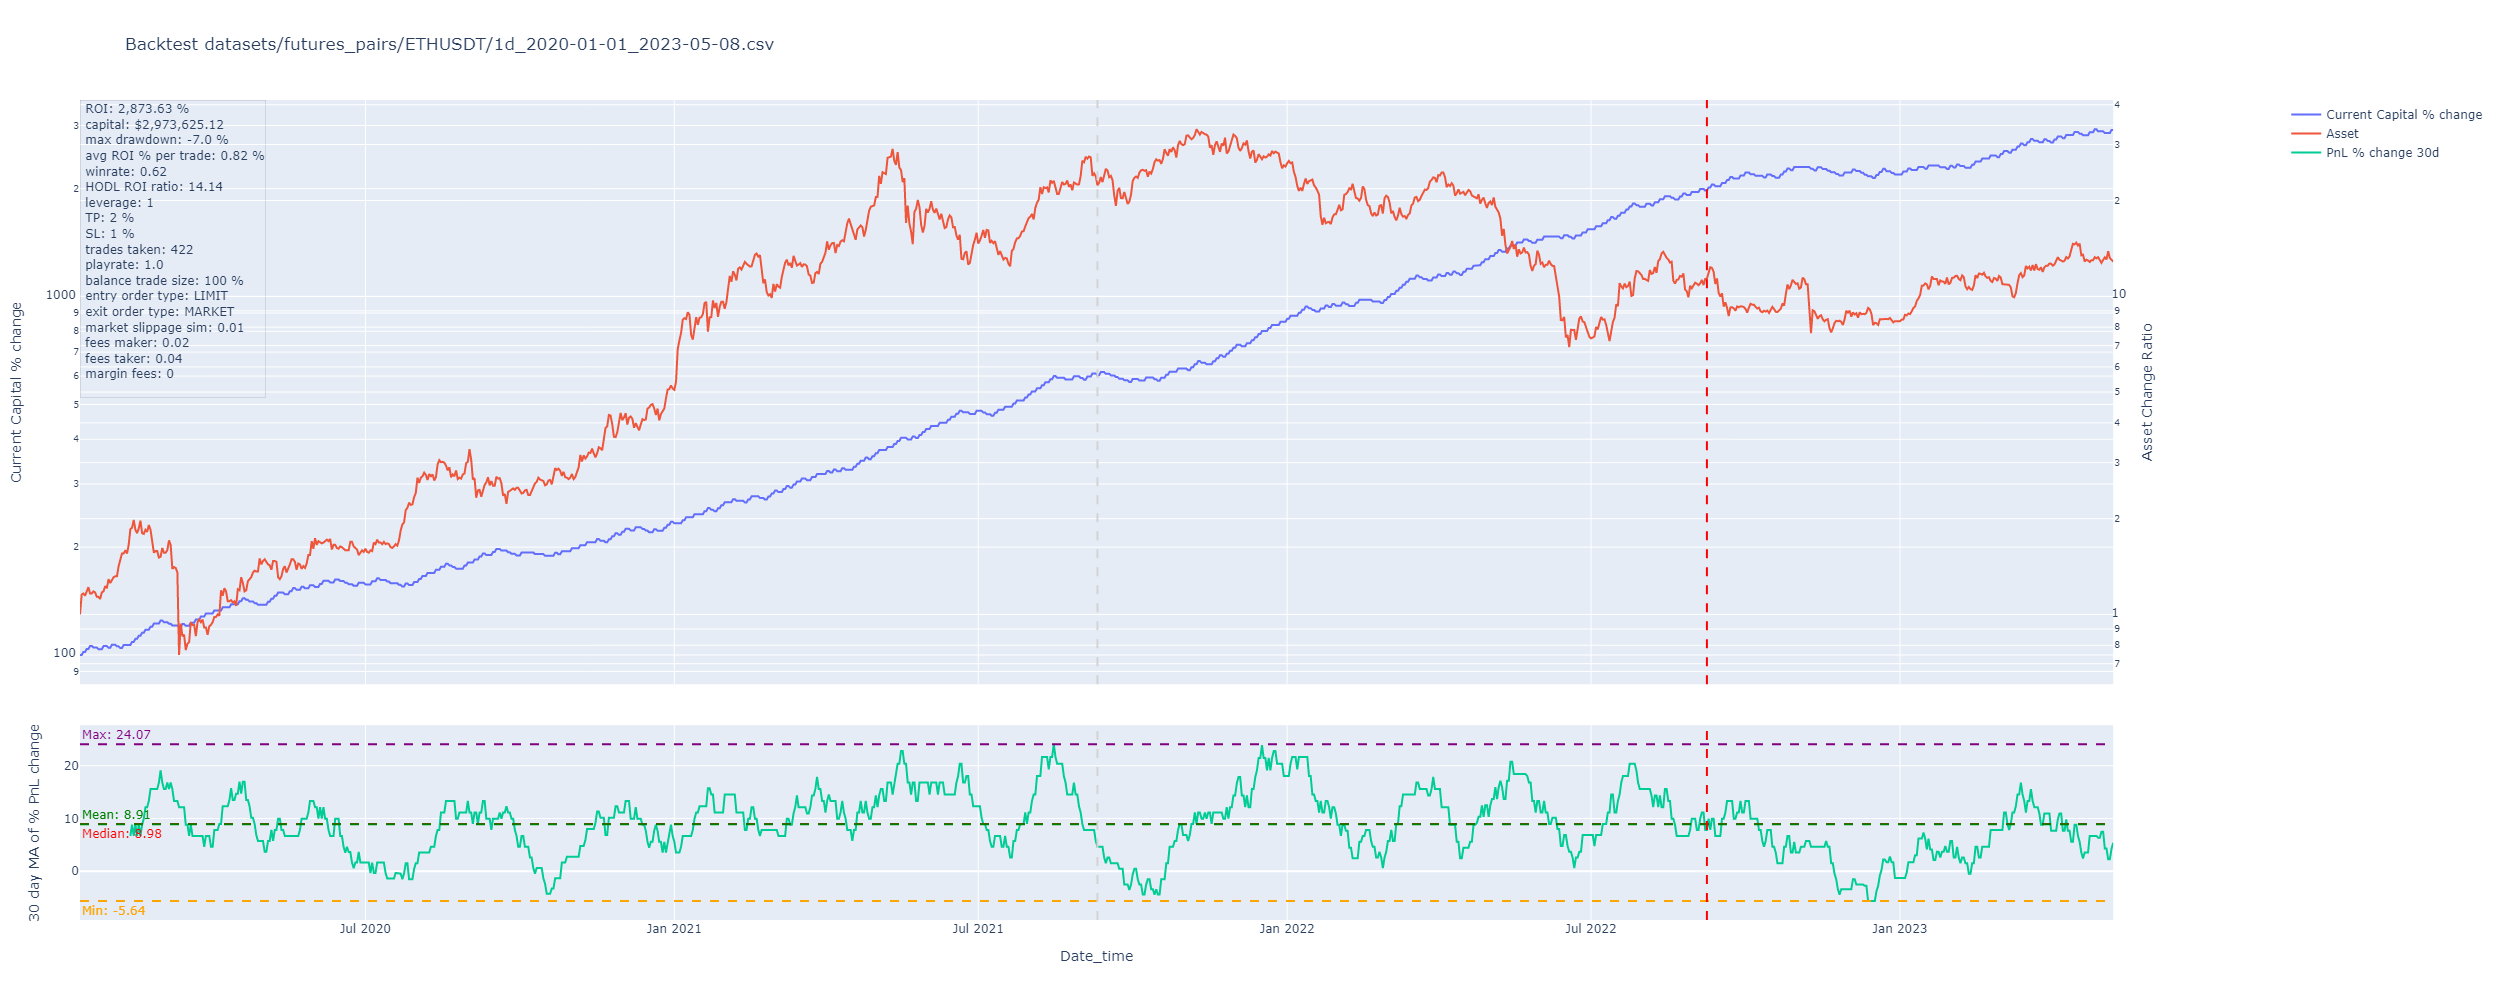

In [ ]:
from IPython.display import Image
Image(filename="backtester/backtest_plot.png")

In [ ]:
# read the csv file with the variables
stats_df = pd.read_csv('backtester/stats.csv', index_col=0)
stats_df

,roi_percentage,max_drawdown,avg_pnl_percentage,winrate
ai_name,,,,
eth_100M_batch_size_128_envs_512_ent_0.15_s0.zip,1898.25,-8.0,0.79,0.61
eth_100M_batch_size_256_envs_256_ent_0.1_s0.zip,1481.40,-9.0,0.71,0.58
eth_100M_batch_size_256_envs_256_ent_0.05_s0.zip,2873.63,-7.0,0.82,0.62


In [ ]:
%cd C:\dev\Python\Mastermind\mastermind\training\Reinforcement_learning

C:\dev\Python\Mastermind\mastermind\training\Reinforcement_learning


# Evaluation

info {'total_reward': 1322.6200000000026, 'total_profit': 1.2949304749872426, 'position': 1}


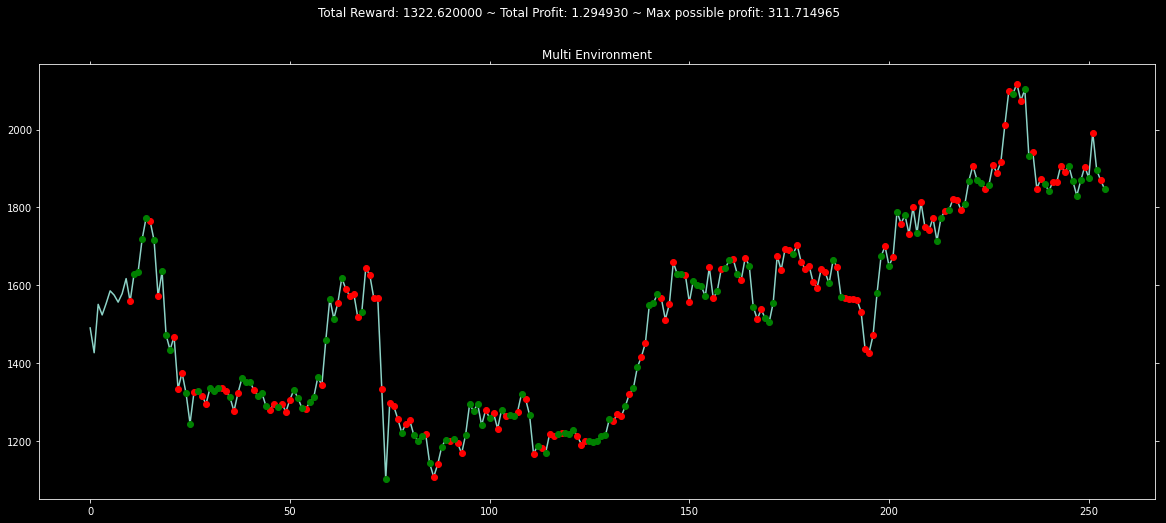

In [ ]:
# Create new GYM environment for testing agent
my_test_env = CryptoEnv(df=gymdf, window_size=window_size, frame_bound=test_frame_bound)

# Load the agent
loaded_model = PPO.load(new_model_name, env=my_test_env, seed=0)

# Reset environment to initial state and get initial observation
obs = my_test_env.reset()

# Perform action and get new state, reward, done, and info
while True:
    obs = obs[np.newaxis, ...]
    action, _states = loaded_model.predict(obs)
    obs, rewards, done, info = my_test_env.step(action[0])
    # If episode done, print info and break loop
    if done:
        print("info", info)
        break
    
    
plt.figure(figsize=(20,8))
plt.cla()
my_test_env.render_all()
plt.title('Multi Environment')
plt.show()

In [ ]:
# plot my_test_env.history['total_profit'] with plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=gymdf['Date'][test_frame_bound[0]:test_frame_bound[1]], y=my_test_env.history['total_reward'],
                    mode='lines',
                    name='total_reward'))
fig.update_layout(title='total_reward')
fig.show()
# save plotly figure
# fig.write_html(f"total_reward_{new_model_name}.html")

In [ ]:
# plot my_test_env.history['total_profit'] with plotly
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=gymdf['Date'][test_frame_bound[0]:test_frame_bound[1]], y=my_test_env.history['total_profit'],
                    mode='lines',
                    name='total_profit'))
fig.update_layout(title='total_profit')
fig.show()
# fig.write_html(f"total_profit_{new_model_name}.html")